# 机器学习，启动！

## 数据读取

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import re


### 读取根据澄清公告得出的虚假新闻

In [6]:
# Read in data
df_clear = pd.read_excel('data_china.xlsx',sheet_name=1,dtype={'股票代码': str})
df_clear.head(3) #检视前三列


,股票代码,新闻发布时间,公司简称,公告地址,新闻澄清日期,原文链接,原文,标题,新闻实际来源,新闻来源备注,...,原文长度,情感分数,真实性（虚假1真实0）,年报资产报酬率（%）,年报资产报酬率TTM（%）,年报营业利润率（%）,年报总资产周转率（次）,年报总资产周转率TTM（次）,年报非流动资产/总资产（%）,情感分数2
0,600141,2015-01-02,兴发集团,http://www.cninfo.com.cn/new/disclosure/detail...,2015-01-06,https://finance.china.com.cn/roll/20150102/288...,30吨高纯食品级磷酸产品出口全球最大软饮料企业可口可乐公司、与世界最大食品制造企业雀巢公司确...,"兴发集团与世界名企""联姻"" 磷酸产品进军全球饮食市场",新华网,NaN,...,865,41.460,1,1.0951,1.0513,1.2332,0.6040,0.6040,79.2394,38
1,002453,2015-01-05,天马精化,http://www.cninfo.com.cn/new/disclosure/detail...,2015-01-07,http://finance.ce.cn/rolling/201501/05/t201501...,近日，苏州市高新区浒墅关镇丹景廷小区住户向《每日经济新闻》反映称，天马精化（002453...,天马精化被指排放刺鼻气体 环保部门要求整改,每日经济新闻,NaN,...,3021,-19.739,1,3.2386,3.2534,2.6251,0.5431,0.5431,60.3453,-19
2,002030,2015-01-07,达安基因,http://www.cninfo.com.cn/new/disclosure/detail...,2015-01-09,https://news.ifeng.com/a/20150107/42875578_0.s...,广东省科技厅原党组书记、厅长李兴华还被指控收受省内6家公司的干股，在它们申请科技扶持资金时提...,收受六家公司干股交由亲属司机代持,其他,NaN,...,2844,18.620,1,6.7978,5.1758,5.9033,0.6366,0.6366,24.8121,18


### 读取包含价格异动的数据

In [13]:
df_price = pd.read_excel('price_code_hold.xlsx',dtype={'股票代码': str})  # 第二个文件
df_price.head(5)

,发布日期,股票代码,数据1,数据2,数据3,数据4,数据5,数据6,数据7,数据8,...,市值大小,牛熊市,机构投资者占比,是否国企,新闻来源,虚假新闻的情绪正负,新闻情绪,新闻逻辑,新闻可信度,新闻不确定性
0,2022-03-13,300482,2022-03-04 00:00:00,-0.046380,-0.091528,0.048530,0.185592,0.192788,0.051773,0.000698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-01,601012,2022-02-21 00:00:00,0.020927,0.034075,0.033518,0.015183,0.043343,0.025033,-0.003048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-23,300124,2020-10-15 00:00:00,-0.023789,0.000008,0.006244,-0.015090,-0.013547,0.005417,-0.009174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-01,2456,2020-08-24 00:00:00,-0.002595,-0.000447,-0.014200,-0.009031,-0.013808,-0.072101,-0.067361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-10-23,600096,2019-10-15 00:00:00,0.004612,-0.000465,0.005348,0.002104,0.090643,-0.024311,-0.025103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 情绪测度

### 将长文本截短

因为Roberta对文本处理不能超过524个tokens，因此需要把文本截短为不超过524个tokens的段落，新的列表中标题和截断的段落都会作为文本进行情感分析。不用股票代码的原因是python比对字符串花不了多久。
>我收回这句话，跑的结果有问题，看来得重写了

In [7]:
news_text = [None]*495   #重复使用append会增加时间复杂度

def cut_txt(text, num, cut_text_temp=[]):
    if len(text) > num:
        cut_text_temp.append(text[:num])
        return cut_txt(text[num:],num, cut_text_temp)
    else:
        cut_text_temp.append(text)
        return cut_text_temp
for i in range(0,len(df_clear)):
    news_text[i] = df_clear["原文"][i]
cut_text = []
label = []
position = 0
for j in range(0,len(news_text)):
    if news_text[j] is None:
        break
    if len(news_text[j])<512:
        cut_text.append(news_text[j])
        label.append(df_clear["标题"][position])
        
    else:
        cut_text_temp = cut_txt(news_text[j],512)
        for temp_len in range(0,len(cut_text_temp)):
            label.append(df_clear["标题"][position])
            cut_text.append(cut_text_temp[temp_len])
    position = position + 1
print(label[1:10]) #如果直接print(label)会卡死，问就是viscode魅力时刻


['兴发集团与世界名企"联姻" 磷酸产品进军全球饮食市场', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改', '天马精化被指排放刺鼻气体 环保部门要求整改']


现在重写，内容和标题作为两个新数据，防止长度不一致造成的循环问题

In [7]:
df_content = df_clear[["股票代码","原文","新闻发布时间"]]

In [14]:
df_titile = df_clear[["股票代码","标题","新闻发布时间"]]

In [9]:
def split_text(row, max_length=500):
    """
    将原文按 max_length 分割，并为每段保留对应的主码（包括股票代码和新闻发布时间）。
    """
    text = row["原文"]
    code = row["股票代码"]
    date = row["新闻发布时间"]
    
    # 按长度 max_length 分割
    chunks = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    
    # 返回主码（股票代码、新闻发布时间）和分割后的内容
    return [{"股票代码": code, "新闻发布时间": date, "分段内容": chunk} for chunk in chunks]

# 应用函数，将结果展开为一个新 DataFrame
result = df_content.apply(split_text, axis=1)  # 每行应用
df_content_cut = pd.DataFrame([item for sublist in result for item in sublist])



### jd
开始调用，这个是基于电商训练的，令人感到沮丧，毕竟电子商务文本和金融类文本有差异

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

model_name = "uer/roberta-base-finetuned-jd-binary-chinese"  # 替换为已微调好的模型
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [15]:
def split_text(text, max_length=512):
    tokens = tokenizer.tokenize(text)
    #tokens = jieba.cut(text,cut_all=False)
    #tokens = ",".join(tokens)
    #print(tokens)
    #print(tokens_1)
    chunk_size = max_length - 2  # Adjust for [CLS] and [SEP] tokens
    chunks = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]

def analyze_sentiment(text):
    segments = split_text(text, max_length=tokenizer.model_max_length)
    sentiments = []
    for segment in segments:
        sentiment = nlp(segment)
        sentiments.extend(sentiment)
    return sentiments

# Sample news_text list
# news_text = ["Sample text 1...", "Sample text 2...", "Sample text 3..."]

# Perform sentiment analysis on each text and store results in a list
cut_text_test = cut_text
results_content = []
results_title = []
for text in cut_text_test:
    result_content = analyze_sentiment(text)
    results_content.append(result_content)
for title in label:
    result_title = analyze_sentiment(title)
    results_title.append(result_title)
# Display results
i=0
result = []
for text, sentiment_content,sentiment_title in zip(cut_text_test, results_content,results_title):
    pattern = re.compile(r'positive', re.IGNORECASE)
    # 遍历列表，检查label并读取score
    for item in sentiment_content:
        if pattern.search(item['label']):
            sentiment_label_content='P'
        else:
            sentiment_label_content="N"
        content_score = item['score']
    for item in sentiment_title:
        if pattern.search(item['label']):
            sentiment_label_title='P'
        else:
            sentiment_label_title="N"
        title_score = item['score']
    result.append({
        'text': text,
        'sentiment_content': sentiment_label_content,
        'conetent_score': content_score,
        'label': label[i],
        'sentiment_title':sentiment_label_title,
        'title_score':title_score
    })
    i = i+1
result_df = pd.DataFrame(result)
result_df.to_csv("result.csv",index=False)

NameError: name 'nlp' is not defined

### bardsai
result.csv可在鄙人github库中获取。虽然如此，显然不知道姜富伟最新在《管理世界》上的那篇论文有什么意义。试一试来自贵系的模型。

>到达金融科技最前沿——人工智能！哎呀妈呀这不是富伟吗？我们还是看看远处的贵系吧

Finance Sentiment ZH (fast) is a distiluse-based model for analyzing sentiment of Chinese financial news. It was trained on the translated version of Financial PhraseBank by Malo et al. (20014) for 10 epochs on single RTX3090 gpu.

The model will give you a three labels: positive, negative and neutral.

### 新预测

In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline

tokenizer = AutoTokenizer.from_pretrained("bardsai/finance-sentiment-zh-fast")
model = AutoModelForSequenceClassification.from_pretrained("bardsai/finance-sentiment-zh-fast")
nlp_bardsai = pipeline("text-classification", model="bardsai/finance-sentiment-zh-fast")



c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
def nlp_bardsai_empty(text=None):
    if not isinstance(text, str):  
        text="特朗普"
    return nlp_bardsai(text)

In [14]:
nlp_bardsai_empty()

[{'label': 'neutral', 'score': 0.9998952150344849}]

In [10]:
nlp_bardsai("特朗普")

[{'label': 'neutral', 'score': 0.9998952150344849}]

In [15]:
# 对每一段进行情绪分析
df_titile["情绪分析结果"] = df_titile["标题"].apply(nlp_bardsai)

# 分解情绪分析结果并扩展列
df_titile["情绪标签"] = df_titile["情绪分析结果"].apply(lambda x: x[0]["label"])
df_titile["情绪分数"] = df_titile["情绪分析结果"].apply(lambda x: x[0]["score"])
df_titile = df_titile.drop(columns=["情绪分析结果"])

# 保存为 CSV 文件
df_titile.to_csv("badrdsai_result_title_test.csv", index=False, encoding="utf-8-sig")

print("CSV 文件已生成：情绪分析结果.csv")

CSV 文件已生成：情绪分析结果.csv


C:\Users\86198\AppData\Local\Temp\ipykernel_20072\4162595065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titile["情绪分析结果"] = df_titile["标题"].apply(nlp_bardsai)
C:\Users\86198\AppData\Local\Temp\ipykernel_20072\4162595065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titile["情绪标签"] = df_titile["情绪分析结果"].apply(lambda x: x[0]["label"])
C:\Users\86198\AppData\Local\Temp\ipykernel_20072\4162595065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

对新闻文本情绪分析

In [11]:
# 对每一段进行情绪分析
df_content_cut["情绪分析结果"] = df_content_cut["分段内容"].apply(nlp_bardsai)

# 分解情绪分析结果并扩展列
df_content_cut["情绪标签"] = df_content_cut["情绪分析结果"].apply(lambda x: x[0]["label"])
df_content_cut["情绪分数"] = df_content_cut["情绪分析结果"].apply(lambda x: x[0]["score"])
df_content_cut = df_content_cut.drop(columns=["情绪分析结果"])

# 保存为 CSV 文件
df_content_cut.to_csv("badrdsai_result_content_test.csv", index=False, encoding="utf-8-sig")

print("CSV 文件已生成：情绪分析结果.csv")

CSV 文件已生成：情绪分析结果.csv


### 评论文本情绪测度

In [16]:
import os
import pandas as pd

# 定义文件夹路径
folder_path =   "D:\mycodelife\workshop\\fake_finance\cleaned_files"
# 输出文件夹路径
output_folder = os.path.join(folder_path, "sentialment_result")
os.makedirs(output_folder, exist_ok=True)  # 如果输出文件夹不存在，则创建

# 遍历文件夹中的所有 CSV 文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # 检查是否是 CSV 文件
        file_path = os.path.join(folder_path, file_name)
        
        # 读取 CSV
        df_comment = pd.read_csv(file_path)
        df_comment = df_comment[["发布时间","标题","内容"]]

        df_comment["标题分析结果"] = df_comment["标题"].apply(nlp_bardsai)
        # 分解标题情绪分析结果并扩展列
        df_comment["标题标签"] = df_comment["标题分析结果"].apply(lambda x: x[0]["label"])
        df_comment["标题分数"] = df_comment["标题分析结果"].apply(lambda x: x[0]["score"])
        df_comment = df_comment.drop(columns=["标题分析结果"])
        df_comment =df_comment.drop(columns=["标题"])

        #内容
        
        df_comment["内容分析结果"] = df_comment["内容"].apply(nlp_bardsai_empty)
        # 分解标题情绪分析结果并扩展列
        df_comment["内容标签"] = df_comment["内容分析结果"].apply(
            lambda x: x[0]["label"] 
        )
        df_comment["内容分数"] = df_comment["内容分析结果"].apply(
            lambda x: x[0]["score"] 
        )
        df_comment = df_comment.drop(columns=["内容分析结果"])
        df_comment =df_comment.drop(columns=["内容"])

        output_path = os.path.join(output_folder, file_name)
        df_comment.to_csv(output_path, index=False)
        # 保存为 CSV 文件

        print(output_path)


D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000007.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000008.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000010.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000012.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000018.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000033.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000078.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000155.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000417.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000509.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000543.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\000558.csv
D:\mycodelife\workshop\fake_finance\clea

# 研究情绪测度内容

对于新闻，将统计“偏移”，即不为中性情绪的占比

In [12]:
df_content_analysis = pd.read_csv("badrdsai_result_content_test.csv")

In [3]:
df_title = pd.read_csv("badrdsai_result_title.csv")

In [13]:
# 新增列：判断是否为 positive、neutral 和 negative
df_content_analysis["neutral"] = df_content_analysis["情绪标签"].apply(lambda x: 1 if x == "neutral" else 0)
df_content_analysis["positive"] = df_content_analysis["情绪标签"].apply(lambda x: 1 if x == "positive" else 0)
df_content_analysis["negative"] = df_content_analysis["情绪标签"].apply(lambda x: 1 if x == "negative" else 0)

# 分组统计
result = df_content_analysis.groupby(["股票代码","新闻发布时间"]).agg(
    # 中性均值，若无中性情绪，填充为 0
    中性均值=("情绪分数", lambda x: x[df_content_analysis.loc[x.index, "neutral"] == 1].mean() if any(df_content_analysis.loc[x.index, "neutral"] == 1) else 0),
    # 积极均值，若无积极情绪，填充为 0
    积极均值=("情绪分数", lambda x: x[df_content_analysis.loc[x.index, "positive"] == 1].mean() if any(df_content_analysis.loc[x.index, "positive"] == 1) else 0),
    # 消极均值，若无消极情绪，填充为 0
    消极均值=("情绪分数", lambda x: x[df_content_analysis.loc[x.index, "negative"] == 1].mean() if any(df_content_analysis.loc[x.index, "negative"] == 1) else 0),
    # 中性占比
    中性占比=("neutral", "mean"),
    # 积极占比
    积极占比=("positive", "mean"),
    # 消极占比
    消极占比=("negative", "mean")
).reset_index()

# 计算每类加权分数
result["中性分数"] = result["中性均值"] * result["中性占比"]
result["积极分数"] = result["积极均值"] * result["积极占比"]
result["消极分数"] = result["消极均值"] * result["消极占比"]

# 仅保留所需列
result = result[["股票代码","新闻发布时间","中性分数", "积极分数", "消极分数"]]

# 保存结果到 CSV 文件
result.to_csv("badrdsai_result_content_test.csv", index=False, encoding="utf-8-sig")


将文本和标题合并在一起

In [9]:
# 合并数据，基于股票代码（假设列名为'code'）
merged_sentiment = pd.merge(df_title, result, on='股票代码', how='inner')  # 'inner'表示只保留共同的股票代码

# 选择特定的列
merged_sentiment =merged_sentiment.drop(columns=["标题"])

merged_sentiment.to_csv("bardsai_anaylsis_content_and_title.csv", index=False, encoding="utf-8-sig")

# 使用统计学习对股价异动进行预测

先划分训练集和预测集

In [30]:
#选择训练的值

# 合并数据，基于股票代码（假设列名为'code'）
merged_df = pd.merge(df_clear, df_price, on='股票代码', how='inner')  # 'inner'表示只保留共同的股票代码

# 选择特定的列
train_data = merged_df[['股票代码', 'car-2-2', '情感分数','年报资产报酬率（%）','年报资产报酬率TTM（%）','年报营业利润率（%）','年报总资产周转率（次）','年报总资产周转率TTM（次）','年报非流动资产/总资产（%）','情感分数2']] 
 # 根据需要替换列名
train_data.head()  # 打印合并后的数据


,股票代码,car-2-2,情感分数,年报资产报酬率（%）,年报资产报酬率TTM（%）,年报营业利润率（%）,年报总资产周转率（次）,年报总资产周转率TTM（次）,年报非流动资产/总资产（%）,情感分数2
0,600141,0.081447,41.460,1.0951,1.0513,1.2332,0.6040,0.6040,79.2394,38
1,600850,0.137959,-8.736,9.2053,8.3214,5.9070,1.4050,1.4050,6.1092,-5
2,600569,0.000136,-36.230,-5.1483,-5.1419,-12.6821,0.6327,0.6327,58.6234,-35
3,600569,0.000136,-62.640,2.6736,2.5357,1.2803,0.8229,0.8229,47.5978,-60
4,600487,-0.103108,0.820,8.0407,7.2373,5.4400,0.9775,0.9775,33.6591,9


将文本情绪合并到该数据中

## 数值型预测-股价价格异动

In [8]:
X = train_data[['情感分数','年报资产报酬率（%）','年报资产报酬率TTM（%）','年报营业利润率（%）','年报总资产周转率（次）','年报总资产周转率TTM（次）','年报非流动资产/总资产（%）','情感分数2']]  # 选择特征列
y = train_data['car-2-2']                   # 选择目标列

In [9]:
# 删除有空缺值的行
X_na = X.dropna()
y_na = y[X_na.index]


### XGBoost进行预测

In [10]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import root_mean_squared_error


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_na, y_na, test_size=0.2, random_state=42)

# 将数据转化为DMatrix格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# 设置参数
params = {
    'objective': 'reg:squarederror',  # 回归
    'eta': 0.1,                      # 学习率
    'max_depth': 3,                  # 树的最大深度
    'eval_metric': 'logloss'         # 评估指标
}

# 训练模型
bst = xgb.train(params, dtrain, num_boost_round=100)

# 进行预测
y_pred = bst.predict(dtest)

# 计算准确率
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.12


### 用SHAP对XGBoost进行检视

In [31]:
import shap
# 使用 SHAP 进行解释
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)


绘图

c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  pl.tight_layout()
c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


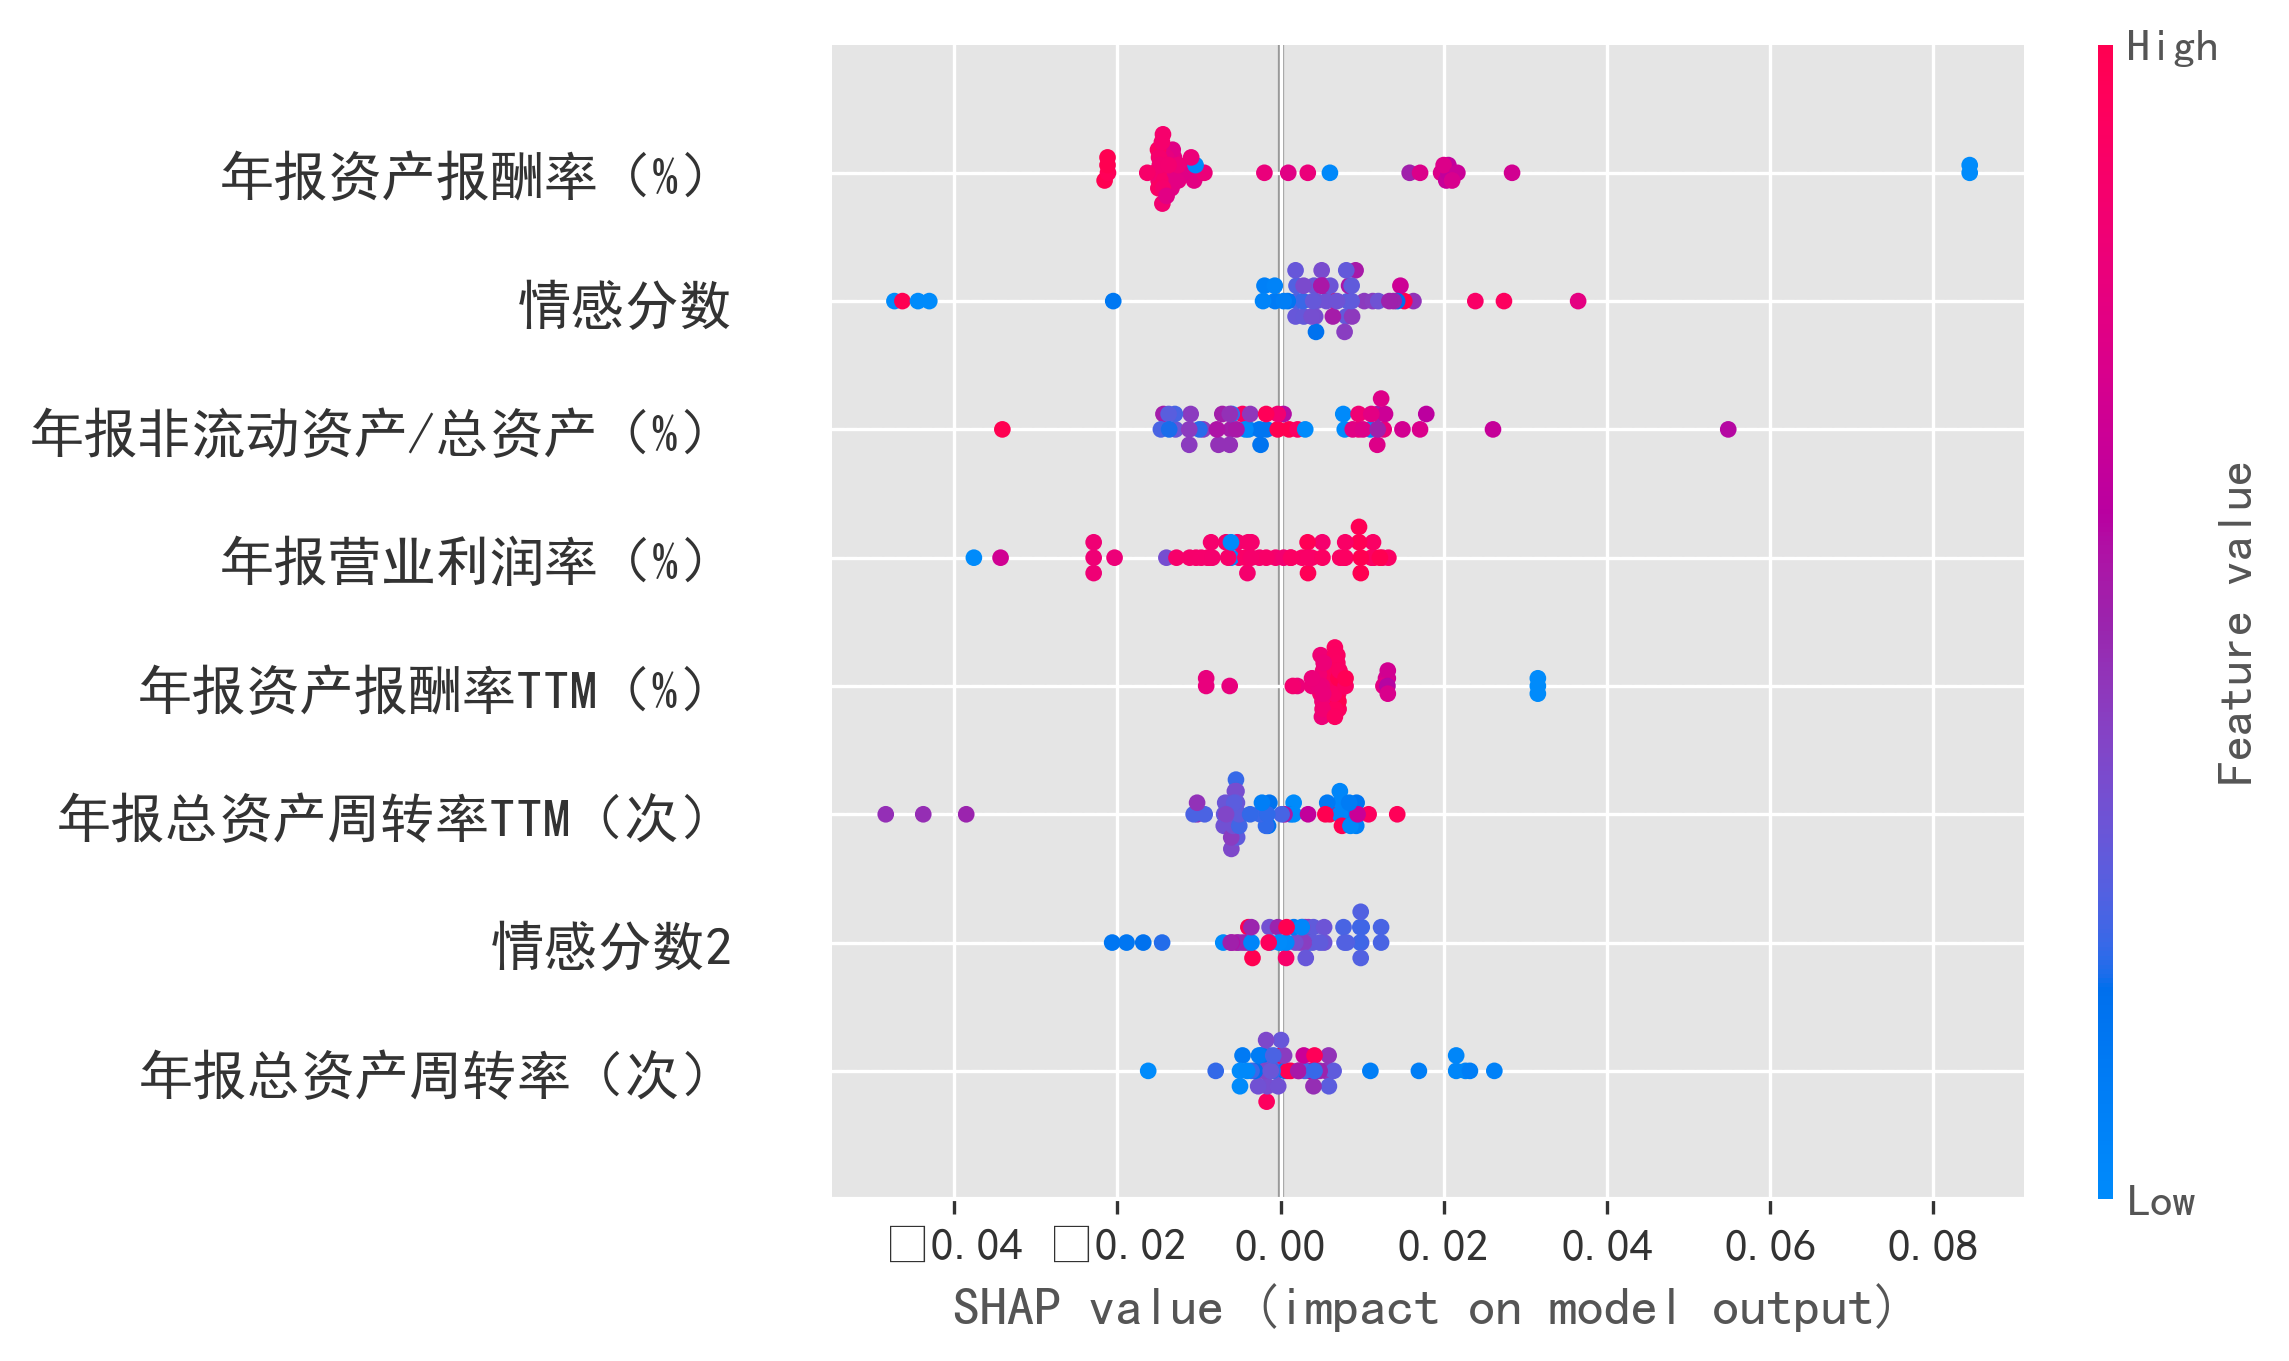

In [34]:

# 示例：假设已经有 shap_values 和 X_test
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# 设置 Matplotlib 的全局字体和分辨率
plt.rcParams['font.size'] = 12  # 调整字体大小
plt.rcParams['figure.dpi'] = 300  # 提高分辨率
plt.rcParams['savefig.dpi'] = 300  # 保存图片时的分辨率
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文字体

# 绘制 SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# 保存图像到本地
plt.savefig('shap_summary_plot.png', bbox_inches='tight')  # 保存完整字符
plt.close()  # 关闭图形，避免重复显示


### 使用反对向量回归机进行预测

调用所需要的包

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


反对向量机不支持空缺值，要删掉

In [14]:
# 创建支持向量回归机 (使用 RBF 核)
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)

# 训练模型
svr_model.fit(X_train, y_train)

# 预测
y_pred = svr_model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("均方误差 (MSE):", mse)
print("决定系数 (R²):", r2)

均方误差 (MSE): 0.03579879611464033
决定系数 (R²): -3.0290707292940215


分别采用三种核函数预测，并绘图

### 使用多层感知机进行预测

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


包含relu,sigmoid,tanh这几种激活函数。最简单的情况是单隐含层，此时relu的结果很不收敛

In [23]:


# 激活函数列表
activations = ['identity', 'logistic', 'tanh', 'relu']
colors = ['red', 'green', 'blue', 'orange']



for activation, color in zip(activations, colors):
    # 创建多层感知机回归模型
    mlp_model = MLPRegressor(
        hidden_layer_sizes=(50,),  # 隐藏层大小
        activation=activation,    # 激活函数
        max_iter=10000,           # 最大迭代次数
        random_state=42
    )

    # 训练模型
    mlp_model.fit(X_train, y_train)

    # 预测
    
    y_pred_test = mlp_model.predict(X_test)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print(activation," MSE is:",mse," R^2 is:",r2)


identity  MSE is: 0.045422425478258206  R^2 is: -4.112187693740489
logistic  MSE is: 0.016318199179272685  R^2 is: -0.8365751311147926
tanh  MSE is: 0.0825964522986988  R^2 is: -8.29603742077014
relu  MSE is: 0.4052108029778453  R^2 is: -44.60552763404474


通过增加隐含层（现有两层），relu的结果能达到收敛

In [24]:


# 激活函数列表
activations = ['identity', 'logistic', 'tanh', 'relu']
colors = ['red', 'green', 'blue', 'orange']



for activation, color in zip(activations, colors):
    # 创建多层感知机回归模型
    mlp_model = MLPRegressor(
        hidden_layer_sizes=(50,50),  # 隐藏层大小
        activation=activation,    # 激活函数
        max_iter=10000,           # 最大迭代次数
        random_state=42
    )

    # 训练模型
    mlp_model.fit(X_train, y_train)

    # 预测
    
    y_pred_test = mlp_model.predict(X_test)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print(activation," MSE is:",mse," R^2 is:",r2)


identity  MSE is: 0.04379119461986377  R^2 is: -3.9285964779009612
logistic  MSE is: 0.011009895869967772  R^2 is: -0.2391380157088827
tanh  MSE is: 0.0385059797196951  R^2 is: -3.333757908913732
relu  MSE is: 0.22401197111653093  R^2 is: -24.21202313470983


继续增加隐含层，可以发现除了identity之外都表现更好

In [25]:


# 激活函数列表
activations = ['identity', 'logistic', 'tanh', 'relu']
colors = ['red', 'green', 'blue', 'orange']



for activation, color in zip(activations, colors):
    # 创建多层感知机回归模型
    mlp_model = MLPRegressor(
        hidden_layer_sizes=(50,50,30),  # 隐藏层大小
        activation=activation,    # 激活函数
        max_iter=10000,           # 最大迭代次数
        random_state=42
    )

    # 训练模型
    mlp_model.fit(X_train, y_train)

    # 预测
    
    y_pred_test = mlp_model.predict(X_test)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print(activation," MSE is:",mse," R^2 is:",r2)


identity  MSE is: 0.45282244092334156  R^2 is: -49.96410606795727
logistic  MSE is: 0.009328399171960666  R^2 is: -0.0498894972489472
tanh  MSE is: 0.0162097342175105  R^2 is: -0.8243676534892725
relu  MSE is: 0.19677434919980707  R^2 is: -21.14649252723309


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# 确保训练数据为 NumPy 数组
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)  # 转换为列向量

# 定义 MLP 模型
class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegression, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 50)  # 隐藏层 1
        self.hidden2 = nn.Linear(50, 30)        # 隐藏层 2
        self.output = nn.Linear(30, 1)          # 输出层 (单值回归)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))         # 激活函数
        x = torch.relu(self.hidden2(x))
        return self.output(x)                  # 输出层无激活函数

# 创建模型
model = MLPRegression(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 转换测试数据为 NumPy 数组
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_pred_test = model(X_test_tensor).detach().numpy()

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(activation," MSE is:",mse," R^2 is:",r2)



relu  MSE is: 0.016363251758480406  R^2 is: -0.8416456934762679


## 对投资者情绪的影响

要先将每日情绪进行统计

In [25]:
import os
# 定义文件夹路径
folder_path =   "D:\mycodelife\workshop\\fake_finance\cleaned_files\sentialment_result"
# 输出文件夹路径
output_folder = os.path.join(folder_path, "sentialment_result_date")
os.makedirs(output_folder, exist_ok=True)  # 如果输出文件夹不存在，则创建

# 遍历文件夹中的所有 CSV 文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # 检查是否是 CSV 文件
        file_path = os.path.join(folder_path, file_name)
        
        # 读取 CSV
        df = pd.read_csv(file_path)
        df = df[["发布时间","标题标签","标题分数"]]

           
        df["日期"] = pd.to_datetime(df["发布时间"]).dt.date

        # 添加辅助列，用于统计情绪
        df["投资者中性"] = df["标题标签"].apply(lambda x: 0 if x == "neutral" else 1)
        df["投资者positive"] = df["标题标签"].apply(lambda x: 1 if x == "positive" else 0)
        df["投资者negative"] = df["标题标签"].apply(lambda x: 1 if x == "negative" else 0)

        # 按日期分组统计
        result = df.groupby("日期").agg(
            投资者中性情绪均值=("标题分数", lambda x: x[df.loc[x.index, "标题标签"] == "neutral"].mean()),
            投资者非中性文本占比=("投资者中性", "mean"),
            positive占比=("投资者positive", "mean"),
            negative占比=("投资者negative", "mean")
        ).reset_index()

        output_path = os.path.join(output_folder, file_name)
        result.to_csv(output_path, index=False)
        print(output_path)

D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000007.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000008.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000010.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000012.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000018.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000033.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000078.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000155.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_result\sentialment_result_date\000417.csv
D:\mycodelife\workshop\fake_finance\cleaned_files\sentialment_re

增加虚假新闻发生时间